## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ian\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization,Activation

def build_mlp(input_shape, output_unit=10, num_neurons=[512, 256, 128], pre_activate=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=n_units,
                                  activation='relu',
                                  name='hidden_layer'+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                  activation='relu',
                                  name='hidden_layer'+str(i+1))(x)
            
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_unit, activation='softmax', name='output_layer')(x)
        
    model = keras.models.Model(inputs=[input_layer], outputs=[out])    
    
    return model

In [9]:
"""Code Here
設定超參數
"""
LEARNING_RATE=1e-3
EPOCHS=30
BATCH_SIZE=[32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM=0.95

In [10]:
import itertools
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE,BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:],pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=optimizer)
    
    model.fit(x_train,y_train,
             epochs=EPOCHS,
             batch_size=bz,
             validation_data=(x_test, y_test),
             shuffle=True)
    
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] ={'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activat

50000/50000 [==============================] - 10s 203us/step - loss: 0.6258 - acc: 0.7781 - val_loss: 2.0282 - val_acc: 0.4424
Epoch 18/30
50000/50000 [==============================] - 10s 202us/step - loss: 0.5781 - acc: 0.7953 - val_loss: 2.3490 - val_acc: 0.4187
Epoch 19/30
50000/50000 [==============================] - 10s 203us/step - loss: 0.5417 - acc: 0.8072 - val_loss: 2.0486 - val_acc: 0.4210
Epoch 20/30
50000/50000 [==============================] - 10s 202us/step - loss: 0.5143 - acc: 0.8160 - val_loss: 2.0439 - val_acc: 0.4798
Epoch 21/30
50000/50000 [==============================] - 10s 205us/step - loss: 0.4739 - acc: 0.8319 - val_loss: 2.2903 - val_acc: 0.4522
Epoch 22/30
50000/50000 [==============================] - 10s 203us/step - loss: 0.4452 - acc: 0.8420 - val_loss: 2.1098 - val_acc: 0.4579
Epoch 23/30
50000/50000 [==============================] - 10s 200us/step - loss: 0.4097 - acc: 0.8566 - val_loss: 2.2134 - val_acc: 0.4434
Epoch 24/30
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 16s 311us/step - loss: 1.6992 - acc: 0.4001 - val_loss: 1.8111 - val_acc: 0.3599
Epoch 2/30
50000/50000 [==============================] - 15s 298us/step - loss: 1.4884 - acc: 0.4682 - val_loss: 1.6674 - val_acc: 0.3988
Epoch 3/30
50000/50000 [==============================] - 15s 298us/step - loss: 1.4081 - acc: 0.5030 - val_loss: 1.7085 - val_acc: 0.4053
Epoch 4/30
50000/50000 [==============================] - 15s 298us/step - loss: 1.3378 - acc: 0.5228 - val_loss: 1.8253 - val_acc: 0.3918
Epoch 5/30
50000/50000 [==============================] - 15s 299us/step - loss: 1.2825 - acc: 0.5431 - val_loss: 1.5828 - val_acc: 0.4478
Epoch 6/30
50000/50000 [==============================] - 15s 298us/step - loss: 1.2349 - acc: 0.5636 - val_loss: 1.5681 - val_acc: 0.4561
Epoch 7/30
50000/50000 [==============================] - 15s 298us/step - loss: 1.1925 - acc: 0.5767 - val_loss: 2.

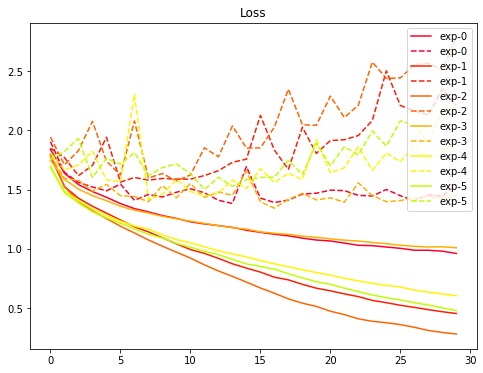

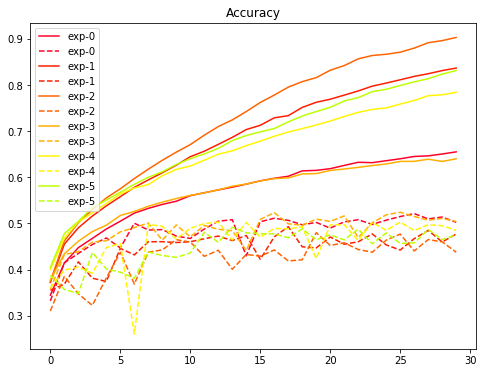

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出

"""
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors

NUM_COLORS=20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

In [5]:
scalarMap